# Regression and classification on the Ising model
## OLS, Ridge, logistic regression and Neural networks

__Note to users of this notebook:__ <br>
In order to use this notebook as it is written, do the following: <br>
1) Save the notebook on your computer. <br>
2) Download the file "IsingData.zip" from [here](https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/) to the folder where the notebook is saved. <br>
3) Unpack the downloaded zip-file in the same location it is stored.<br>

### Abstract
A regression problem, relating the spins to the energy in the 1D Ising model, and a classification problem, classifying the phase in the 2D Ising model, is studies with own developed methods. An own developed class with the classical regression techniques OLS and Ridge gives almost exactly the same parameter estimates as Mehta et al. (2018) finds using Sci-Kit learn. All models gave largest parameter values for the neigboring spins. Only the Lasso-model was able to get the solution fully correct. Optimal values of regularization for the Lasso and Ridge models was identified. We develop a bootstrap function and find that the change in testing MSE for Ridge and Lasso is driven by variance changes, and not bias changes. A neural network class, which we create, gives pretty similar results to Keras neural network for a simple test regression problem. For the Ising-model regression problem, the results from our neural network and Keras do not correspond well. Our neural network gives good training fit, wite R2 score close to 1, but bad testing fit, with R2 score below 0.5. The results do not increase above a certain degree of regularization, indicating absence of overfitting. The results seem robbust to the training rate. The performance of our own logistic regression class on the classification problem was poor, and depends on the chosen optimzation solver. The mini-batch stochastic gradient descent solver does best, with testing accuracy aorund 70 %, while the standard gradient descent does worst with testing accuracy below 50 %. The stochastic gradient descent did almost as well as the mini-batch stochastic gradient descent. There seems to be little gain from increasing the number of iterations or changing the learning rate furhter. The result for the standard gradient descent corresponds well with those found by Mehta et al. (2018) with gradient descent. The mini-barch stochastic gradient descent results corresponds well with the results Mehta et al. (2018) get using the liblin-solver. Our neural network worked very well on the Ising-model classification problem. The performance of our neural network was much better than with the logistic regression. Except for single neuron hidden layer model, our neural network gave almost perfect accuracy both for the training and the testing set for three different learning rates. The results of our neural network match the results we get by applying Keras with the same inputs. 

# Introduction
With the rise of computer power and amount of available data, data analysis is widely use. Regression and classficiation are two main types of methods that are used in data analysis in all kinds of fields. Hence knowledge about regression and classification is vital. In this report we will study both regression and classification problems. The cases will be on the widely used Ising-model. <br>

There are several powerful machine learning/data analysis packages avaibale that makes data anlysis easy to perform. Examples of such packages for Python is Sci-Kit learn and Keras. A potential problem with these packages, is that it is not easy to see what is really going on inside them. In order to reduce the error potential related to applying machine learning packages, knowledge about the algoirthms behind the different methods of the packages, is essential. Several algorithms will be developed with own code in this report. <br> 

Both classical and more modern methods for regression and classification will be developed. For regression we will implement the classical methods OLS and the Ridge from scratch. For classification we will implement the  calssical method logistic regression for scratch. As a modern method, we will develop our own neural network with a single hidden layer from scratch. The neural network will be applied to both the regression and the classification problem. <br>

When developing own methods it is important to have baseline cases to compare the results agains. In our case we will compare some of the results of our methods to the results of Mehta et al. (2018). Mehta et al. (2018) uses Sci-Kit learn for the OLS and Ridge estimators for the regression case and for the logistic regression in the classification case. For the neural network results for regression we will compare our results to results produced by Keras. <br>

Not only is it important to know the algorithms, but also what to expect from different algorithms applied to the same problem. We will compare the results from the classical methods to those of the neural network. <br>

Finally, this report may differ in form from the standard of scientific papers. A scientific paper is often polished, with only the main results displayed. In order to increase the transparancy and reproductability of the material in our report, we give the reader all the code behind the results. Having all the code available, the reader can see for him or herself exactly what is done. Furthermore, if the reader shoud wish to perform his or her own analysis based on the same material, it would be very easy for him or her to start from this report. <br>

The regression problem will be anlyses first, and then the classfication problem will be analysed. The theory is included in the analysis, where it fits naturally. We end the report in the conclusion section where the main results are listed and discussed.



# Regression of the Ising-model energies
In this part we will compare the performance of the classic regression methods OLS, Ridge and Lasso to the performance of Neural Network. We construct a dataset representing a 1D lattice of 40 spins. Furthermore we generate energies assuming the classig model where it is only the neighboroing spins that contribute to energy. <br>

## Regression: The classical methods
For the classical cases we estimate a model that considers the possibility of all spin combinations contributing to the energy. If the classical models are good, they will predict non-zero parameters only for the diaginal element of the spin matrix. The diagonal matrix reprensents the neigbooring spins, and we created the energies from neigboring spins only. <br>

Before we construct the data and perform the analysis, we construc a class performing the classical methods OLS and Ridge. For Lasso we will apply Sci-Kit learn. The implementation follows the standard equations, with one small exception: We apply the SVD for the OLS method. The SVD is less sensitive to singularity in the matrix that must be inverted. For a brief theoretical overview of the classical regression methods, see the theory section of our [previous project report](https://github.com/kaaja/ADAML/blob/master/m1/m1Class.ipynb). <br>

After importing of modules and packages, the class follows.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn
seaborn.set(style="white", context="notebook", font_scale=1.5, 
            rc={"axes.grid": True, "legend.frameon": False,
"lines.markeredgewidth": 1.4, "lines.markersize": 10})
seaborn.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4.5})

#seaborn.set(style="ticks", context="talk")
plt.style.use("dark_background")
seaborn.set_style({'grid.color': '.4'})

#seaborn.set_style("darkgrid")


from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from collections import OrderedDict

import scipy.linalg as scl
import time

In [4]:
class myRegression:
    """Built from MHJ lecture slides: 
    https://compphysics.github.io/MachineLearning/doc/pub/Regression/html/._Regression-bs107.html
    """
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.XHat = np.c_[np.ones_like(y), X]
        #self.XHat = np.concatenate((np.ones(len(X))[:, np.newaxis], X),\
         #   axis=1)
    
    def ols(self):
        u, s, vt = scl.svd(self.XHat)
        self.betaHat = vt.T @ scl.pinv(scl.diagsvd(s, u.shape[0], vt.shape[0])) @ u.T @ self.y
        return self.betaHat
    
    def ridge(self, lmbda, printTime=False):
        startTime = time.time()
        self.betaHat = self.XHat.T @ self.y\
                @ scl.inv(self.XHat.T @ self.XHat + np.eye(self.XHat.shape[1], self.XHat.shape[1]) * lmbda)
        endTime = time.time()
        timeUsed = endTime - startTime
        if printTime:
            print('Time ridge1', timeUsed)
        return self.betaHat
    
    def ridge2(self, lmbda, printTime=False):
        startTime = time.time()
        alphas = np.zeros(1)
        alphas[0] = lmbda
        U, s, Vt = scl.svd(self.XHat, full_matrices=False)
        d = s / (s[:, np.newaxis].T ** 2 + alphas[:, np.newaxis])
        betaHat = np.dot(d * U.T.dot(self.y), Vt).T
        #betaHat = (((d * U.T) @ self.y) @ Vt).T
        self.betaHat = np.squeeze(betaHat) 
        endTime = time.time()
        timeUsed = endTime - startTime
        if printTime:
            print('Time ridge2', timeUsed)
        return self.betaHat
    
    def predict(self, X):
        XHat = np.c_[np.ones_like(X[:,0]), X]
        return XHat @ self.betaHat
    


## Classical regression:  Data
The energies are constructed by code from [Mehta's notebook 4.](https://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB_CVI-linreg_ising.html). In order to compare our results to Mehta et al. (2018) as well as possible, we use the same split between training and testing data as Mehta et al. (2018).

In [5]:
import scipy.sparse as sp
np.random.seed(12)

import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

### define Ising model aprams
# system size
L=40

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(10000,L))

def ising_energies(states,L):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    J=np.zeros((L,L),)
    for i in range(L):
        J[i,(i+1)%L]-=1.0
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)

    return E
# calculate Ising energies
energies=ising_energies(states,L)

# All possible spin combinations
# reshape Ising states into RL samples: S_iS_j --> X_p
states=np.einsum('...i,...j->...ij', states, states)
shape=states.shape
states=states.reshape((shape[0],shape[1]*shape[2]))
# build final data set
Data=[states,energies]

# define number of samples
n_samples=400
# define train and test data sets
X_train=Data[0][:n_samples]
Y_train=Data[1][:n_samples] #+ np.random.normal(0,4.0,size=X_train.shape[0])
X_test=Data[0][n_samples:3*n_samples//2]
Y_test=Data[1][n_samples:3*n_samples//2] #+ np.random.normal(0,4.0,size=X_test.shape[0])

## Classical regression: Testing own class agains sci-kit learn
Below we compute and compare the coefficient matrices from our own class to Sci-Kit learn. The test uses the Ising-model data loaded above. The test-function tests the max relative ratio between our coefficient matrix elements and the corresponding coefficient elements from Sci-Kit learn. Both OLS and Ridge are tested.

In [6]:
import sklearn.linear_model as skl

def test_ols():    
    myRidge = myRegression(X_train, Y_train)
    omega = myRidge.ols()
    clf = skl.LinearRegression(fit_intercept=False).fit(myRidge.XHat, Y_train) 
    J_own = omega[1:].reshape(L, L)
    J_sk = clf.coef_[1:].reshape(L, L)
    #print('\n J_own/J_scikit \n', np.divide(J_own, J_sk))
    #print('Max and min method ', np.max(np.divide(J_own, J_sk)), 
     #     np.min(np.divide(J_own, J_sk)))
    tolerance = 1e-7
    success = (abs(np.max(np.divide(J_own, J_sk)) - 1) < tolerance ) and \
            (abs(np.min(np.divide(J_own, J_sk)) - 1) < tolerance )
    msg = 'Max relative differences from sci-kit ',  abs(np.max(np.divide(J_own, J_sk)) - 1), \
                                        abs(np.min(np.divide(J_own, J_sk)) - 1)
    assert success, msg
    
def test_ridge():
    myRidge = myRegression(X_train, Y_train)
    lmbda = 0.1
    omega = myRidge.ridge(lmbda)
    clf = skl.Ridge(alpha=lmbda, fit_intercept=False).fit(myRidge.XHat, Y_train) 
    J_own = omega[1:].reshape(L, L)
    J_sk = clf.coef_[1:].reshape(L, L)
    #print('\n J_own/J_scikit \n', np.divide(J_own, J_sk))
    #print('Max and min method ', np.max(np.divide(J_own, J_sk)), 
          #np.min(np.divide(J_own, J_sk)))
    tolerance = 1e-7
    success = (abs(np.max(np.divide(J_own, J_sk)) - 1) < tolerance ) and \
            (abs(np.min(np.divide(J_own, J_sk)) - 1) < tolerance )
    msg = 'Max relative differences from sci-kit ',  abs(np.max(np.divide(J_own, J_sk)) - 1), \
                                        abs(np.min(np.divide(J_own, J_sk)) - 1)
    assert success, msg
    
test_ols()
test_ridge()

We see that the test passes for both the OLS and the Ridge method. The maximal ratio of the elements in the coefficient matrices from our method and Sci-Kit learn is less than $10^{-7}$. Hence our class practically reproduces the coefficient matrices from Sci-Kit learn.<br>

## Classical regression: Parameter values
Now that we have confidence in our own developed methods, since they passed the tests, we will apply these methods and compare the results to those of Mehta et al. (2018). We start by making regressions for the same regularization parameter values as Mehta et al. (2018). We plot the parameter values with a hotmap, with the lattice dimension along both axis. Each pixel in this hotmap reprensent a combination of spins. The diagonals next to the diagonal represent the neigboroing spins. A model performing well should only have significant parameter values close to the diagonal.<br>



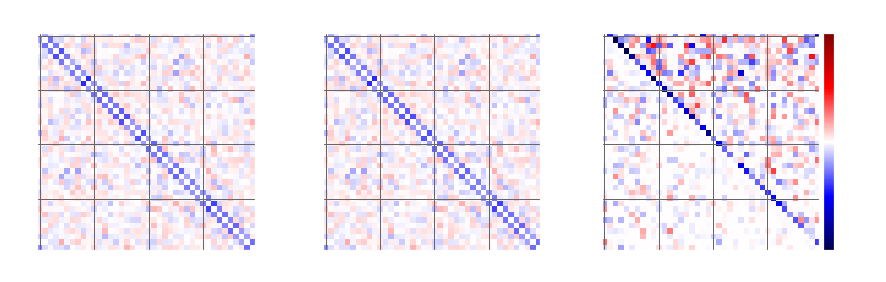

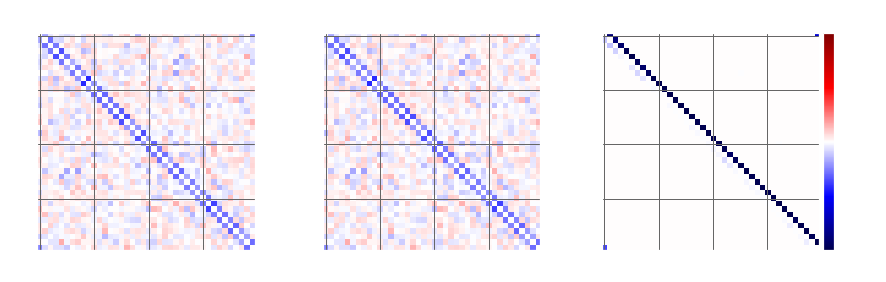

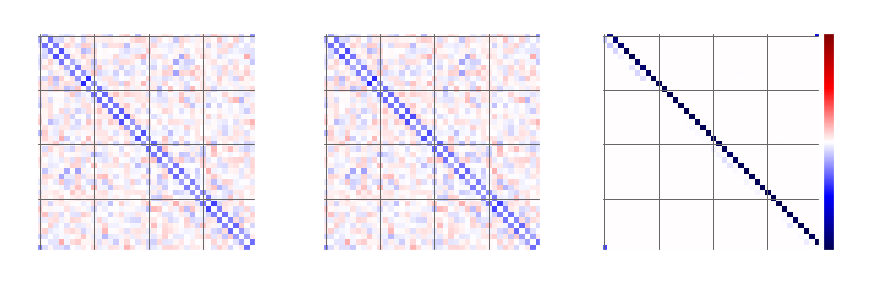

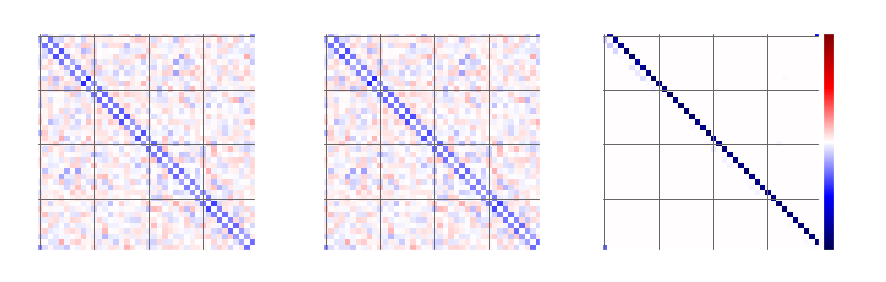

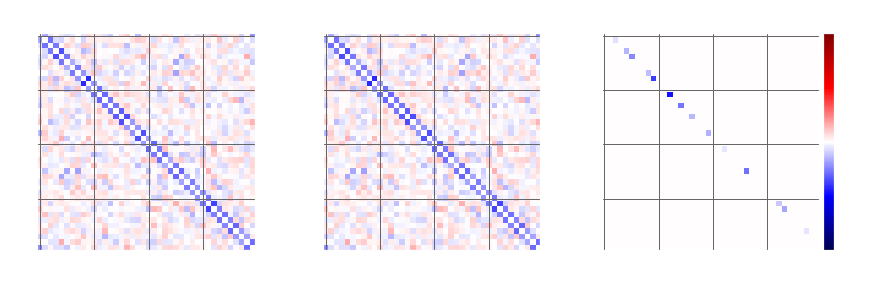

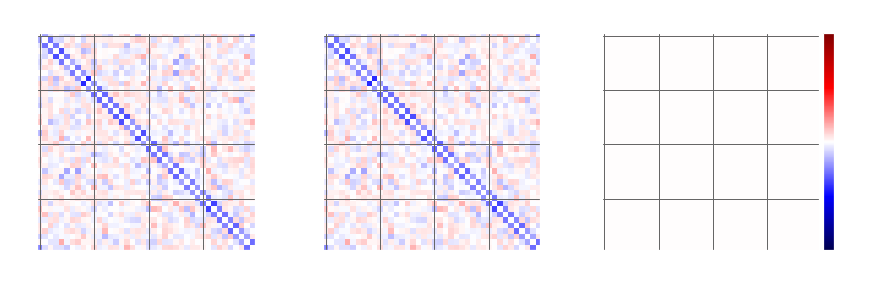

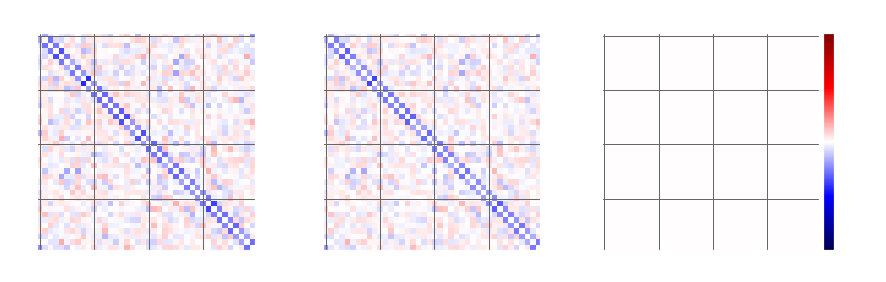

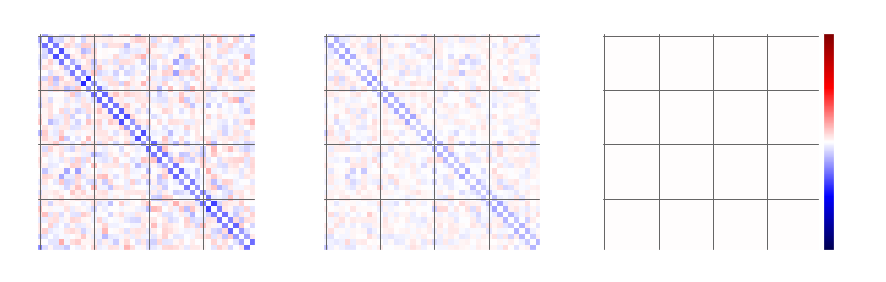

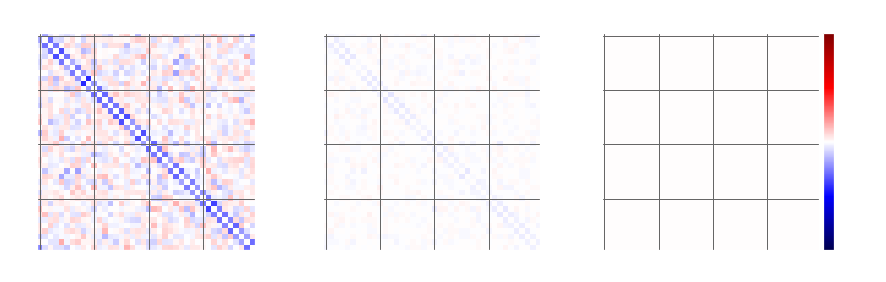

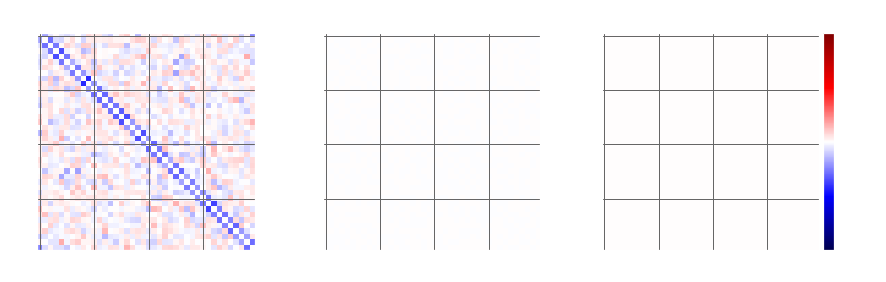

In [26]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
%matplotlib inline

# set up Lasso and Ridge Regression models
#leastsq=linear_model.LinearRegression()
leastsq=myRegression(X_train, Y_train)
#ridge=linear_model.Ridge()
ridge=myRegression(X_train, Y_train)
lasso = linear_model.Lasso()

# define error lists
train_errors_leastsq = []
test_errors_leastsq = []
train_mse_leastsq = []
test_mse_leastsq = []

train_errors_ridge = []
test_errors_ridge = []
train_mse_ridge = []
test_mse_ridge = []

train_errors_lasso = []
test_errors_lasso = []
train_mse_lasso = []
test_mse_lasso = []

# set refularisations trength values
lmbdas = np.logspace(-4, 5, 10)

#Initialize coeffficients for ridge regression and Lasso
coefs_leastsq = []
coefs_ridge = []
coefs_lasso=[]

def r_squared(y, y_hat):
    return 1 - np.sum((y - y_hat) ** 2) / np.sum((y - np.mean(y_hat)) ** 2)

for lmbda in lmbdas:
    
    ### OLS
    coeffsLs = leastsq.ols()
    coefs_leastsq.append(coeffsLs) 
    train_errors_leastsq.append(r_squared(Y_train, leastsq.predict(X_train))) 
    test_errors_leastsq.append(r_squared(Y_test, leastsq.predict(X_test)))
    train_mse_leastsq.append(mean_squared_error(Y_train, leastsq.predict(X_train))) 
    test_mse_leastsq.append(mean_squared_error(Y_test, leastsq.predict(X_test)))
    
    ###  Ridge 
    coeffsRidge = ridge.ridge(lmbda)
    coefs_ridge.append(coeffsRidge) 
    train_errors_ridge.append(r_squared(Y_train, ridge.predict(X_train))) 
    test_errors_ridge.append(r_squared(Y_test, ridge.predict(X_test)))
    train_mse_ridge.append(mean_squared_error(Y_train, ridge.predict(X_train)))
    test_mse_ridge.append(mean_squared_error(Y_test, ridge.predict(X_test)))
    
    ###  Lasso 
    lasso.set_params(alpha=lmbda) # set regularisation parameter
    lasso.fit(X_train, Y_train) # fit model
    coefs_lasso.append(lasso.coef_) # store weights
    train_errors_lasso.append(lasso.score(X_train, Y_train))
    test_errors_lasso.append(lasso.score(X_test,Y_test))
    train_mse_lasso.append(mean_squared_error(Y_train, lasso.predict(X_train)))
    test_mse_lasso.append(mean_squared_error(Y_test, lasso.predict(X_test)))

    ### plot Ising interaction J
    J_leastsq=np.array(coeffsLs[1:]).reshape((L,L))
    J_ridge=np.array(coeffsRidge[1:]).reshape((L,L))
    J_lasso=np.array(lasso.coef_).reshape((L,L))

    cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow(J_leastsq,**cmap_args)
    axarr[0].set_title('$\\mathrm{OLS}$',fontsize=16)
    axarr[0].tick_params(labelsize=16)
    
    axarr[1].imshow(J_ridge,**cmap_args)
    axarr[1].set_title('$\\mathrm{Ridge},\ \\lambda=%.4f$' %(lmbda),fontsize=16)
    axarr[1].tick_params(labelsize=16)
    
    im=axarr[2].imshow(J_lasso,**cmap_args)
    axarr[2].set_title('$\\mathrm{LASSO},\ \\lambda=%.4f$' %(lmbda),fontsize=16)
    axarr[2].tick_params(labelsize=16)
    
    divider = make_axes_locatable(axarr[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(im, cax=cax)
    
    cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    cbar.set_label('$J_{i,j}$',labelpad=-40, y=1.12,fontsize=16,rotation=0)
    
    fig.subplots_adjust(right=2.0)
    
    plt.show()

__Figure 1:__ Coefficient estimates different regularization levels. OLS, Ridge, Lasso. <br>
_The Ridge and OLS estimators are not able to breake the symmetry, giving equal weight to neigbooring coefficients closest to the diagonal. The Lasso estimator gives the correct result, for certain regularization values. <br>

The OLS estimation seems to have largest values along the nearest diagnaol points to the diagonal, which represents the neigboiring spins. It is good that the OLS estimator gives largst coefficients along the these neigbouring diagonals, since the data was created by only neighbouring spins. <br>

The weights equal around $\pm 0.5$ for most models along the neghboring diagonals to the main diagonal. This suggests that the models are not able to split symmetry. See Methta et al. (2018) p.25 for more on this. <br>

The only model that is able to breake the symmetry, is the Lasso model for certain parameters. For certain parameters the Lasso model predicts the value $-1$ along the diagonal, which represents the neigboring spins. In these cases the Lasso model fits the real model. <br>
    
Finally we observe that the results are very similar to those of [notebook4 of Mehta et al. (2018)](https://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB_CVI-linreg_ising.html.).  
    
## Classical regression: MSE and R2
We continue in the same track as Mehta et al. (2018), and analyse the model performance studying the R2 score for both the training and test samples for the different regularization paramters. This will tell us the optimal hyperparameter values.

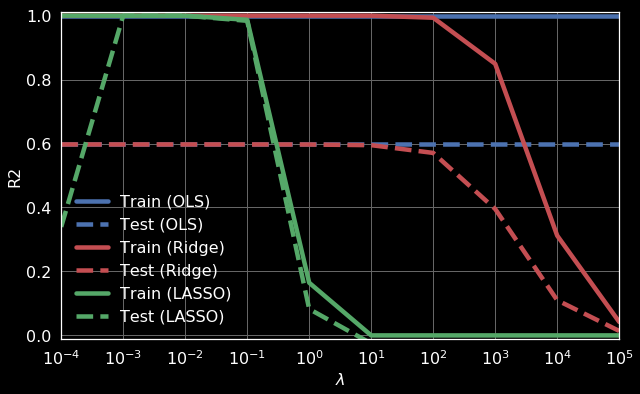

In [30]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, train_errors_leastsq, 'b',label='Train (OLS)')
plt.semilogx(lmbdas, test_errors_leastsq,'--b',label='Test (OLS)')
plt.semilogx(lmbdas, train_errors_ridge,'r',label='Train (Ridge)')#,linewidth=1)
plt.semilogx(lmbdas, test_errors_ridge,'--r',label='Test (Ridge)')#,linewidth=1)
plt.semilogx(lmbdas, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lmbdas, test_errors_lasso, '--g',label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left',fontsize=16)
plt.ylim([-0.01, 1.01])
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('R2',fontsize=16)
plt.tick_params(labelsize=16)
#plt.palette="pastel"
plt.show()

__Figure 2:__ R2 scores. Test and training. All models. Regression. 1D. <br>
_There is a maximum $\lambda$ for both Ridge and Lasso. At some $\lambda$ both the Ridge and the Lasso model starts doing worse._ <br>

Lasso is the model that gives the best fit, since it gives the highest test R2. <br>

The optimal $\lambda$ is around $10^{-2}$ for Lasso and $10$ for Ridge. The optima are found where the test performance peaks. <br>

We note that the figure above looks very similar to the figure in Mehta et at.'s (2018) [notebook 4](https://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB_CVI-linreg_ising.html).

Lets take a look at the MSEs.

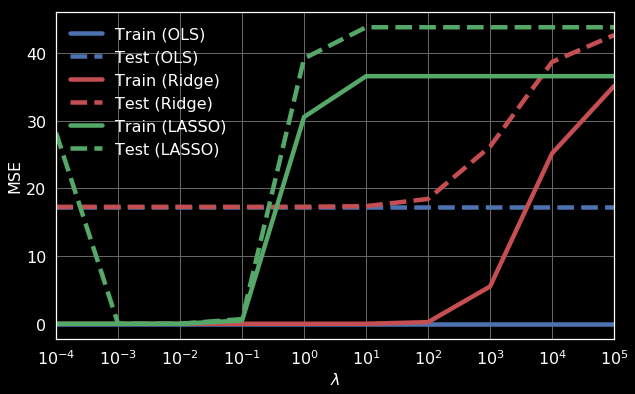

In [31]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, train_mse_leastsq, 'b',label='Train (OLS)')
plt.semilogx(lmbdas, test_mse_leastsq,'--b',label='Test (OLS)')
plt.semilogx(lmbdas, train_mse_ridge,'r',label='Train (Ridge)')#,linewidth=1)
plt.semilogx(lmbdas, test_mse_ridge,'--r',label='Test (Ridge)')#,linewidth=1)
plt.semilogx(lmbdas, train_mse_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lmbdas, test_mse_lasso, '--g',label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='upper left',fontsize=16)
#plt.ylim([-0.01, 1.01])
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.tick_params(labelsize=16)
#plt.palette="pastel"
plt.show()

__Figure 3:__ MSE. Test and training. All models. Regression. 1D. <br>
_The story is the same as for the R2-score: There are critical $\lambda$'s for which the test MSE of Ridge and Lasso start to increase. The critical $\lambda$'s are the same as for the R2-score._

The story is the same for MSE as for R2. Lasso is the best model.

## Classical regression: Bias-variance decomposition
From above we have that the shape of the test MSE depends on the regularization. The regularization reflects the complexity of the models. Higher regularization implies that more parameters get lower value, lowering the effective number of parameters in the model, reducing the complexity. <br>

The change in test MSE can come from two sources: Bias and variance. High complexity normally goes hand in hand with low bias and high variance, and the oppsotite for low complexity. Using the bootstrapping method, which is described in the section "A better bias-variance decomposition: Bootstrap " in [project 1](https://github.com/kaaja/ADAML/blob/master/m1/m1Class.ipynb), we will now perform a bias-variance decomposition of the above results. <br>

The following shows the bootstrap-function and the commands for running the bootstrap.

In [7]:
from collections import OrderedDict
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
%matplotlib inline

def bootstrap(xData, yData,  R, lmbda):
    n = xData.shape[0] 
    inds = np.arange(n); 

    mseMatrixUnknownF =  OrderedDict()
    sdMatrixUnknownF =  OrderedDict()
    bias2MatrixUnknownF =  OrderedDict()
    totalMatrixUnknownF =  OrderedDict()
    residualDictUnknownF = OrderedDict()
    
    models = ['ridge', 'lasso']
    
    for i in models:
        mseMatrixUnknownF[i] = np.zeros(n)
        sdMatrixUnknownF[i] = np.zeros(n)
        bias2MatrixUnknownF[i] = np.zeros(n)
        totalMatrixUnknownF[i] = np.zeros(n)
        residualDictUnknownF[i] = OrderedDict()
        for j in range(n):
            residualDictUnknownF[i][j] = []    
                                                                                                                                        
    for i in range(R):
        idxTrain = np.random.randint(0,n,n)
        idxValid = np.setdiff1d(np.union1d(inds, idxTrain ), np.intersect1d(inds, idxTrain))
        
        x_train = xData[idxTrain]
        y_train = yData[idxTrain]
        x_valid = xData[idxValid]
        y_valid = yData[idxValid]
        
        #ridge.set_params(alpha=lmbda) # set regularisation parameter
        #ridge.fit(x_train, y_train) # fit model
        #yPredictRidge = ridge.predict(x_valid)
        ridge.ridge(lmbda)
        yPredictRidge = ridge.predict(x_valid)     

         
        lasso.set_params(alpha=lmbda) # set regularisation parameter
        lasso.fit(x_train, y_train) # fit model
        yPredictLasso = lasso.predict(x_valid)
        
        for i in range(len(idxValid)):
            residualDictUnknownF[models[0]][i].append(y_valid[i] -yPredictRidge[i])
            residualDictUnknownF[models[1]][i].append(y_valid[i] -yPredictLasso[i])
            
    mseUnknownF = OrderedDict()
    sdUnknownF = OrderedDict()
    bias2UnknownF = OrderedDict()
    totalUnknownF = OrderedDict()
        
    for model in models:
        for i in range(n):
            mseMatrixUnknownF[model][i] = np.mean([(residualDictUnknownF[model][i][j])**2 for j in range(len(residualDictUnknownF[model][i]))])#np.mean( (residualDictUnknownF[key])**2 )
            sdMatrixUnknownF[model][i] = np.var( residualDictUnknownF[model][i] )
            bias2MatrixUnknownF[model][i] = ( np.mean(residualDictUnknownF[model][i]) )**2
            totalMatrixUnknownF[model][i] = sdMatrixUnknownF[model][i] + \
    bias2MatrixUnknownF[model][i]
        mseUnknownF[model] = np.nanmean(mseMatrixUnknownF[model])
        sdUnknownF[model] = np.nanmean(sdMatrixUnknownF[model])
        bias2UnknownF[model] = np.nanmean(bias2MatrixUnknownF[model])
        totalUnknownF[model] = np.nanmean(totalMatrixUnknownF[model])
            
    return mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF

#leastsq=linear_model.LinearRegression()
#ridge=linear_model.Ridge()
leastsq=myRegression(X_train, Y_train)
ridge=myRegression(X_train, Y_train)
lasso = linear_model.Lasso()
lmbdas = np.logspace(-4, 6, 11) #lmbdas = np.logspace(-4, 5, 10)
R = 50
xData = X_train
yData = Y_train
mses, sds, biases, totals = [], [], [], []
for lmbda in lmbdas:
    mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF = bootstrap(xData, yData,  R, lmbda)   
    mses.append(mseUnknownF)
    sds.append(sdUnknownF)
    biases.append(bias2UnknownF)
    totals.append(totalUnknownF)

Now we make plot of the bootstrap results.

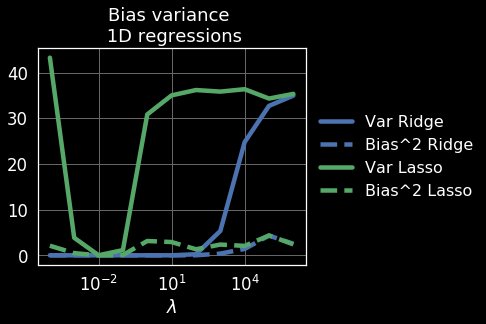

"\nfig, ax = plt.subplots()\nax.semilogx(lmbdas, np.array(varPlot[models[0]])/np.array(msePlot[models[0]]), 'b',label='Var Ridge')\nax.semilogx(lmbdas, np.array(biasPlot[models[0]])/np.array(msePlot[models[0]]), '--b',label='Bias^2 Ridge')\nax.semilogx(lmbdas, np.array(varPlot[models[1]])/np.array(msePlot[models[1]]), 'g',label='Var Lasso')\nax.semilogx(lmbdas, np.array(biasPlot[models[1]])/np.array(msePlot[models[1]]), '--g',label='Bias^2 Lasso')\nax.set_xlabel(r'$\\lambda$')\nax.set_title('Bias variance shares \n 1D regressions')\n#fig.legend(loc='right',fontsize=16)\nbox = ax.get_position()\nax.set_position([box.x0, box.y0, box.width * 0.8, box.height])\nax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 16)\nplt.show()\n"

In [11]:
msePlot = OrderedDict()
varPlot = OrderedDict()
biasPlot = OrderedDict()
totalPlot = OrderedDict()

models = ['ridge', 'lasso']
for model in models:
    msePlot[model] = []
    varPlot[model] = []
    biasPlot[model] = []
    totalPlot[model] = []


for model in models:
    for i in range(len(mses)):
        msePlot[model].append(mses[i][model])
        varPlot[model].append(sds[i][model])
        biasPlot[model].append(biases[i][model])
        totalPlot[model].append(totals[i][model])

#print(mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF)
fig, ax = plt.subplots()
ax.semilogx(lmbdas, varPlot[models[0]], 'b',label='Var Ridge')
ax.semilogx(lmbdas, biasPlot[models[0]], '--b',label='Bias^2 Ridge')
ax.semilogx(lmbdas, varPlot[models[1]], 'g',label='Var Lasso')
ax.semilogx(lmbdas, biasPlot[models[1]], '--g',label='Bias^2 Lasso')
ax.set_xlabel(r'$\lambda$')
ax.set_title('Bias variance \n 1D regressions')
#fig.legend(loc='right',fontsize=16)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)\
, fontsize = 16)
plt.show()

'''
fig, ax = plt.subplots()
ax.semilogx(lmbdas, np.array(varPlot[models[0]])/np.array(msePlot[models[0]]), 'b',label='Var Ridge')
ax.semilogx(lmbdas, np.array(biasPlot[models[0]])/np.array(msePlot[models[0]]), '--b',label='Bias^2 Ridge')
ax.semilogx(lmbdas, np.array(varPlot[models[1]])/np.array(msePlot[models[1]]), 'g',label='Var Lasso')
ax.semilogx(lmbdas, np.array(biasPlot[models[1]])/np.array(msePlot[models[1]]), '--g',label='Bias^2 Lasso')
ax.set_xlabel(r'$\lambda$')
ax.set_title('Bias variance shares \n 1D regressions')
#fig.legend(loc='right',fontsize=16)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)\
, fontsize = 16)
plt.show()
'''

__Figure 4:__ Bias-variance decomposition. Ridge and Lasso. 1D regression. <br>
_It is increased variance that drives the rise of MSE._ <br>

When interpreting the above figure, we must keep in min that the smallest $\lambda$'s are overfitting the models. For Lasso we see that the variance comes down as $\lambda$ is increased from the lowest level. This implies that there was overfitting for the lowst $\lambda$'s. The bias for Lasso is farly constant, reflecting that the average error does not vary much with $\lambda$. When restricting the parameters a lot, the Lasso model again becomes sensitive to the training set used. At $\lambda=10^{-1}$ there is a jump in the variance for Lasso. <br>

For Ridge everything is pretty constant up to $\lambda=10^3$. At $\lambda = 10^{3}$ the variance of Ridge starts to increase, reflecting that Ridge model becomes sensitive to the training data. A small change in training data gives very different models. We had expected also the Ridge model to have a higher variance for the lowest $\lambda$, as Lasso did, since we are overfitting at low levels of $\lambda$. Perhaps even smaller levels of $\lambda$ would be necessary for Ridge to have a higher starting variance.

## Regression: Neural networks
Now we will use Neural networks to analyse the same regression problem as we above did with the classical regression methods. As for the classical regression methods, we construct our own class for Neural networks. Furthermore we compare the results from our neural network to the results from Keras. <br>

## Regression: Back propagtion. A derivation
Before we go to the implementation of the neural networks, we will derive some of the main equations. The central equations for a neural network is the equations for the weight updates, the backward propation algorithm. Reading different texts about this theme may be confusing. When deriving the backward propagation algorithm, most authors introduce many more terms than necessary for understanding the algorithm. Hence it is easy for a reader new to the field to keep the focus of what is going on. We will now try to make the derivation easier by not introducing unnessecary new terms along the way. The derivation assumes a squared distance cost function, which is often used in regression problems. However, using e.g. cross-entropy does not change the results much (in fact nothing when one considers the activation functions that are usually applied with the different cost functions). <br>


Notation: <br>
$a_k^l$ is the activation at node $k$ in layer $l$. $a_k^L$ is the same in the output layer, and $a_k^{l-1}$ is the same in the input layer.<br>
$z_k^l$ is the input to the activation function $f$ at node $k$ in layer $l$.<br>
$w_{jk}^l$ is the weight from node $j$ in layer $l-1$ to node $k$ in layer $l$.<br>

We are minimizing a cost function with respect to weights.
The weights will be updated with gradient descent

\begin{align}
	w_{ij}^l \leftarrow w_{ij}^l - \eta \frac{\partial{C}}{\partial{w_{ij}^l}}.
\end{align}

We start by calculating the output layer weight updates:

\begin{align}
w_{ij}^L &= w_{ij}^L - \eta \frac{\partial{C}}{\partial{w_{ij}^L}}\\
 &=
w_{ij}^L - \eta  \frac{\partial}{\partial w_{ij}^L}\; \Big( \frac{1}{2} \sum_{k=1}^{N_L} (a_k^L - t_k)^2 \Big)\\
&=w_{ij}^L - \eta\frac{\partial}{\partial a_j^L}\; \Big( \frac{1}{2} \sum_{k=1}^{N_L} (a_k^L - t_k)^2 \Big)\;\frac{\partial a_j^L}{\partial w_{ij}^L}\\
&=w_{ij}^L - \eta(a_j^L - t_j) \; \frac{\partial (a_j^L - t_j)}{\partial a_j^L}\; \frac{\partial}{\partial w_{ij}^L}\; \Bigg(f\Big(z_j^L(w_{ij}^L) \Big)\Bigg)\\
&=w_{ij}^L - \eta(a_j^L - t_j) \;\frac{\partial}{\partial z_j^L} \;\Big(f(z_j^L) \Big)\; \frac{\partial z_j^L}{\partial w_{ij}^L}\\
&=w_{ij}^L - \eta(a_j^L - t_j) \; f'(z_j^L) \; \frac{\partial }{\partial w_{ij}^L}\;\Big(\sum_{m=1}^{N_L} (w_{mj}^L a_m^l + b_j^L) \Big)\\
&=w_{ij}^L - \eta(a_j^L - t_j) \; f'(z_j^L) \; a_i^l\\
&=w_{ij}^L - \eta\delta_j^L a_i^l.
\end{align}


Next we compute the inner weight updates

\begin{align*}
w_{ij}^l &=w_{ij}^l - \eta \frac{\partial{C}}{\partial{w_{ij}^l}}\\
 &= w_{ij}^l - \eta\frac{\partial}{\partial w_{ij}^l} \sum_{k=1}^{N_L} \frac{1}{2} \;(a_k^L - t_k)\\
&= w_{ij}^l - \eta\frac{\partial}{\partial a_j^l}\Big( \sum_{k=1}^{N_L}\; \frac{1}{2}\; (a_k^L - t_k)^2 \Big) \;\frac{\partial a_j^l}{\partial z_j^l} \; \frac{\partial z_j^l}{\partial w_{ij}^l}\\
&= w_{ij}^l - \eta\sum_{k=1}^{N_L} \;(a_k^L - t_k) \; \frac{\partial (a_k^L - t_k)}{\partial a_k^L} \; \frac{\partial a_k^L}{\partial a_j^l}\; \frac{\partial f(z_j^l)}{\partial z_j^l} \; \frac{\partial}{\partial w_{ij}^l} \Big(\sum_{m=1}^{N_L} w_{mj}^l a_m^{l-1} + b_j^l\Big)\\
&= w_{ij}^l - \eta\sum_{k=1}^{N_L} \;(a_k^L - t_k)\; \frac{\partial f(z_k^L)}{\partial z_k^L}\; \frac{\partial z_k^L}{\partial a_j^l}\; f'(z_j^l)\; a_i^{l-1}\\
&= w_{ij}^l - \eta\sum_{k=1}^{N_L} (a_k^L - t_k)\; f'(z_k^L)\; \frac{\partial (\sum_{m=1}^{N_L} w_{mk}^L a_m^l + b_k^L)}{\partial a_j^l}\; f'(z_j^l)\; a_i^{l-1}\\
&= w_{ij}^l - \eta\sum_{k=1}^{N_L} (a_k^L - t_k)\; f'(z_k^L)\;w_{jk}^L\; f'(z_j^l)\; a_i^{l-1}\\
&= w_{ij}^l - \eta\sum_{k=1}^{N_L} \delta_k^L \;w_{jk}^L\; f'(z_j^l)\; a_i^{l-1}\\
&= w_{ij}^l - \eta\delta_j^l\; a_i^{l-1}.
\end{align*}


Now we need to do the same for the biases. The derivations are exactly the same as for the weights, with the difference that the last chain in the chain rule now becomes $1$ and not $a_i$, since $\frac{\partial}{\partial b_j^l}\Big(\sum_{m=1}^{N_L} (w_{mj}^l a_m^{l-1} + b_j^l)\Big) = 1$. \\ 

For the biases we end up with

\begin{align}
b_j^L &= b_j^L - \eta \frac{\partial{C}}{\partial b_j^L}\\
	&=b_j^L - \eta  \delta_j^L
\end{align}

and 

\begin{align}
b_j^l &= b_j^l - \eta \frac{\partial{C}}{\partial b_j^l}\\
	&=b_j^l - \eta  \delta_j^l
\end{align}

In the implemented algorithm we first computed the $\delta$'s and then adjust the weights. 

## Regression: The NN-solver class
We start by presenting the neural network class. The network has one hidden layer. The user determines the number of hidden layer neurons and the type of activation function in the different layes. The network applies a form of stochastic gradient with mini batches. 

In [5]:
class NeuralNetwork:
    """
    Based on the lecture notes of Morten Hjorth-Jensen.
    https://compphysics.github.io/MachineLearning/doc/pub/NeuralNet/html/NeuralNet.html
    """
    def __init__(
        self,
        X_data,
        Y_data,
        n_hidden_neurons=50,
        n_categories=10,
        epochs=10,
        batch_size=100,
        eta=0.1,
        lmbd=0.0,
        activationFunctionHidden='sigmoid',
        activationFunctionOutput='linear'
    ):
        
        
        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        if X_data.ndim == 1:
            self.n_features = 1
        else:
            self.n_features = X_data.shape[1]
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        
        if activationFunctionHidden=='sigmoid':
            self.activationFunctionHidden = self.sigmoid
            self.derivativeHidden = self.sigmoidDerivative

        if activationFunctionHidden=='relu':
            self.activationFunctionHidden = self.relu
            self.derivativeHidden = self.reluDerivative

        
        if activationFunctionOutput == 'linear':
            self.activationFunctionOutput = self.linear
            self.derivativeOutput = self.linearDerivative
    
        if activationFunctionOutput == 'sigmoid':
            self.activationFunctionOutput = self.sigmoid
            self.derivativeOutput = self.sigmoidDerivative
            
        if activationFunctionOutput == 'softMax':
            self.activationFunctionOutput = self.softMax
        

        self.create_biases_and_weights()
        
    def sigmoid(self, z):
        return 1./(1 + np.exp(-z))
    
    def sigmoidDerivative(self, z):
        return self.sigmoid(z)*(1. - self.sigmoid(z))
    
    def linear(self, z):
        return z
    
    def linearDerivative(self, z):
        return 1
    
    def softMax(self, z_o):
        exp_term = np.exp(z_o)
        probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        return probabilities
    
    def relu(self, x):
        return x * (x > 0)

    def reluDerivative(self, x):
        return 1. * (x > 0)

    def create_biases_and_weights(self):
        #self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        #self.hidden_weights = np.random.uniform(low=-.05, high=.05, size=(self.n_features, self.n_hidden_neurons))
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)*np.sqrt(2./self.n_features)
        self.hidden_bias = np.zeros(self.n_hidden_neurons) #+ 0.01

        #self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        #self.output_weights  = np.random.uniform(low=-.05, high=.05, size=(self.n_hidden_neurons, self.n_categories))
        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)*np.sqrt(2./self.n_hidden_neurons)

        self.output_bias = np.zeros(self.n_categories) #+ 0.01

    def feed_forward(self):
        # feed-forward for training
        self.z_h = np.matmul(self.X_data, self.hidden_weights) + self.hidden_bias
        self.a_h = self.activationFunctionHidden(self.z_h) # changed

        self.z_o = np.matmul(self.a_h, self.output_weights) + self.output_bias

        #exp_term = np.exp(self.z_o)
        #self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        self.a_o = self.activationFunctionOutput(self.z_o)# Changed
        
    def feed_forward_out(self, X):
        # feed-forward for output
        if X.ndim == 1:
            X = X.reshape(-1,1)
        z_h = np.matmul(X, self.hidden_weights) + self.hidden_bias
        a_h = self.activationFunctionHidden(z_h)

        z_o = np.matmul(a_h, self.output_weights) + self.output_bias
        a_o = self.activationFunctionOutput(z_o)# Changed
        return a_o
        #exp_term = np.exp(z_o)
        #probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        #return probabilities
        
        

    def backpropagation(self):
        #error_output = (self.z_o - self.Y_data)#*self.derivativeOutput(self.z_o) # changed
        #error_output = self.probabilities - self.Y_data

        error_output = self.a_o - self.Y_data
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.derivativeHidden(self.z_h)#* self.a_h * (1 - self.a_h) # changed

        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
        self.hidden_bias_gradient = np.sum(error_hidden, axis=0)

        if self.lmbd > 0.0:
            self.output_weights_gradient += self.lmbd * self.output_weights
            self.hidden_weights_gradient += self.lmbd * self.hidden_weights

        self.output_weights -= self.eta * self.output_weights_gradient
        self.output_bias -= self.eta * self.output_bias_gradient
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias -= self.eta * self.hidden_bias_gradient

    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        if self.activationFunctionOutput != self.linear:
            return np.argmax(probabilities, axis=1)
        else:
            return probabilities
    

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            #data_indices = np.random.permutation(self.n_inputs) # Based on keras documentation
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]
                
                if self.X_data.ndim == 1:
                    self.X_data = self.X_data.reshape(-1,1)
                
                if self.Y_data.ndim == 1:
                    self.Y_data = self.Y_data.reshape(-1,1)
                    

                self.feed_forward()
                self.backpropagation()
                
    def train2(self):
        """
        MHJ's train + my grad descent2. 
        Differences: -where randomization takes place: Each epoch or each batch
                     - endogenuous learning rate
        """
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            #for j in range(self.iterations):
            indices = np.random.permutation(self.n_inputs)
            X = self.X_data_full[indices]
            y = self.Y_data_full[indices]
            for j in range(0, self.n_inputs, self.batch_size):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = X[j:j+self.batch_size] #self.X_data_full[chosen_datapoints]
                self.Y_data = y[j:j+self.batch_size] #self.Y_data_full[chosen_datapoints]
                
                if self.X_data.ndim == 1:
                    self.X_data = self.X_data.reshape(-1,1)
                
                if self.Y_data.ndim == 1:
                    self.Y_data = self.Y_data.reshape(-1,1)
                    
                def learning_schedule(t, t0=5, t1=50):
                    return t0/(t+t1)
                
                self.eta = learning_schedule(i*self.iterations+j)

                self.feed_forward()
                self.backpropagation()
                
    def stochasticGradientDescent2(self, nEpochs=50, batchSize=20,t0=5, t1 = 50):
        """ Modified version of MHJ's version in MHJ's lecture notes """
        
        def learning_schedule(t):
            return t0/(t+t1)
        
        observations = len(self.yData)
        cost_history = np.zeros(nEpochs)
        n_batches = int(observations/batchSize)

        self.betaHat = np.random.random(self.features + 1) - .5
        
        costBest = 1e9
        for epoch in range(nEpochs):
            cost =0.0
            indices = np.random.permutation(observations)
            X = self.xData[indices]
            y = self.yData[indices]
            for i in range(0,observations,batchSize):
                X_i = X[i:i+batchSize]
                y_i = y[i:i+batchSize]
                
                X_i = np.c_[np.ones(len(X_i)),X_i]
                self.sigmoid(X_i @ self.betaHat)
                pHat = self.sigmoidOutput            
                gradients = -X_i.T @ (y_i - pHat)
                eta = learning_schedule(epoch*n_batches+i)
                self.betaHat -= eta*gradients
                cost += self.calculateCost(X_i,y_i)
            cost_history[epoch]  = cost
            if cost_history[epoch] < costBest:
                costBest = cost
                betaBest = self.betaHat
        return self.betaHat, cost_history, betaBest

## NN regression: Test of the solver class
As a test as to our neural network class works, we construct a simple regression problem and solve this problem both with our class and Keras. The test case is constructed by the help of Sci-Kit learn's method "make_regression", which we apply to construct a problem with two features.

In [14]:
def test_NN():
    np.random.seed(1)
    from sklearn.datasets import make_regression
    from sklearn.preprocessing import MinMaxScaler

    X, y = make_regression(n_samples=100, n_features=2, noise=0.1, random_state=1)
    scalarX, scalarY = MinMaxScaler(), MinMaxScaler()
    scalarX.fit(X)
    scalarY.fit(y.reshape(100,1))
    X = scalarX.transform(X)
    y = scalarY.transform(y.reshape(100,1))

    epochs = 1000
    batch_size = 10
    eta = 0.01
    lmbd = 0# 0.01
    n_hidden_neurons = 4
    n_categories = 1
    activationFunctionHidden='relu' #'sigmoid'
    activationFunctionOutput='linear'

    dnn = NeuralNetwork(X, y, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                        n_hidden_neurons=n_hidden_neurons, n_categories=n_categories, 
                       activationFunctionHidden=activationFunctionHidden, activationFunctionOutput=activationFunctionOutput)
    dnn.train()
    Xnew, a = make_regression(n_samples=3, n_features=2, noise=0.1, random_state=1)
    Xnew = scalarX.transform(Xnew)
    test_predict = dnn.predict(Xnew)
    print('Own class:')
    for i in range(len(Xnew)):
        print("X=%s, Predicted=%s" % (Xnew[i], test_predict[i]))


    # Keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense

    model = Sequential()
    model.add(Dense(n_hidden_neurons, input_dim=2, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='sgd')
    model.fit(X, y, epochs=1000, verbose=0)
    ynew = model.predict(Xnew)
    # show the inputs and predicted outputs
    print('\nKeras:')
    for i in range(len(Xnew)):
        print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))
    tolerance = 0.2   
    success = np.max(abs(np.divide(test_predict,ynew)-1)) < tolerance
    msg = 'Max ratio prediction own class to Keras ',  np.max(abs(np.divide(test_predict,ynew)-1))
    assert success, msg
test_NN()

Own class:
X=[0.29466096 0.30317302], Predicted=[0.17325358]
X=[0.39445118 0.79390858], Predicted=[0.74482594]
X=[0.02884127 0.6208843 ], Predicted=[0.40329772]

Keras:
X=[0.29466096 0.30317302], Predicted=[0.17367606]
X=[0.39445118 0.79390858], Predicted=[0.7323273]
X=[0.02884127 0.6208843 ], Predicted=[0.3565045]


__Table 1:__ Predictions own class and Keras. Test problem. Regression.<br>
_The predictions from our own class correspond fairly well to the predictions from Keras._ <br>

We see that our Neural network produce predictions that are decently close to the predictions of Keras. The test-function tests whether the max ratio of predictions between our class and Keras exceeds 20 oer cent, which it does not. <br>

Our network does not create the exact same solution as Keras, but our network seems to work. One possible reason for the discrapency between the results from our method and Keras can be the difference in SGD solver. It is unclear exactly how the SGD-solver of Keras works.

## NN-regression: Our class
We turn to the main task: fitting a neural network linking the spins to the energies in the Ising model. We start by solving this with our Neural network class. <br>

Since we are dealing with regression, we apply a linear activation function in the output layer. A linear activation function is unlimited and does not restrict the output values in the same way as e.g. a Sigmoid function. Furhter we apply Relu as activation function in the hidden layer. 

In [6]:
epochs = 100
batch_size = 32
n_hidden_neurons = 128
n_categories = 1
activationFunctionHidden='relu' #'sigmoid'
activationFunctionOutput='linear'

etas = np.logspace(-5, -3, 3)
lmbdas = np.logspace(-1,3, 5)

r2TrainMatrix = np.zeros((len(etas), len(lmbdas)))
r2TestMatrix = np.zeros_like(r2TrainMatrix)
mseTrainMatrix = np.zeros((len(etas), len(lmbdas)))
mseTestMatrix = np.zeros_like(r2TrainMatrix)



models = np.zeros((len(etas), len(lmbdas)), dtype=object)

for i, eta in enumerate(etas):
    for j, lmbd in enumerate(lmbdas):

        dnn = NeuralNetwork(X_train, Y_train, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                            n_hidden_neurons=n_hidden_neurons, n_categories=n_categories, 
                           activationFunctionHidden=activationFunctionHidden, \
                            activationFunctionOutput=activationFunctionOutput)
        dnn.train()
        models[i][j] = dnn
        #dnn.train2()
        
        train_predict = dnn.predict(X_train)
        mseTrain = mean_squared_error(Y_train, train_predict)
        mseTrainMatrix[i][j] = mseTrain
        r2Train = r2_score(Y_train, train_predict)
        r2TrainMatrix[i][j] = r2Train
        
        test_predict = dnn.predict(X_test)
        mseTest = mean_squared_error(Y_test, test_predict)
        mseTestMatrix[i][j] = mseTest
        r2Test = r2_score(Y_test, test_predict)
        r2TestMatrix[i][j] = r2Test
        
        #print('\neta: ', eta, 'lambda: ', lmbd)
        #print('Train-R2: ', r2Train)
        #print('Test-R2: ', r2Test)

Now we'll plot the results in a heatmap table.

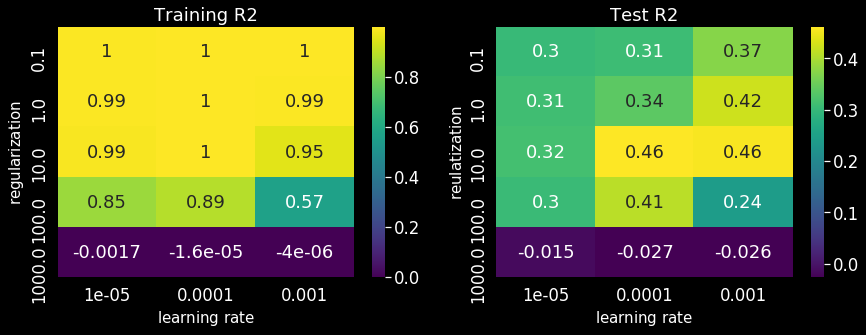

In [7]:
x = [str(i) for i in etas]
y = [str(i) for i in lmbdas]

fontsize = 15
fig, (ax, ax2) = plt.subplots(1,2, figsize=(12.5,5))
seaborn.heatmap(r2TrainMatrix.T, annot=True, ax=ax, cmap='viridis')
ax.set_title('Training R2')
ax.set_xticklabels(x) 
ax.set_yticklabels(y)
ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
ax.set_ylabel('$\\mathrm{regularization\\ }$',fontsize=fontsize)

seaborn.heatmap(r2TestMatrix.T, annot=True, ax=ax2, cmap='viridis')
ax2.set_xticklabels(x)
ax2.set_yticklabels(y)
ax2.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
ax2.set_ylabel('$\\mathrm{reulatization\\ }$',fontsize=fontsize)
ax2.set_title('Test R2')

plt.tight_layout()

plt.show()

__Figure 5:__ R2 score for different combinations of the learning rate and the regularization parameter. Training and test. Own neural network. <br>
_Except for the largest regularizatin parameters, we almost always get perfect fit for the training set. The fit for the testing set is bad. The performance on the testing set increases with the degree of regularization up to a point._

We see that our neural network generalizes badly to the testing data. The R2-score on the testing set is less than 0.5. On the other hand the training data fit is very good. The discrapency between training and test set performance could be a sign of overfitting of the network. Overfitting is common in cases with good training performance and bad testing performance. We see that the testing set performance goes up with the degree of regularization, up to a point. The increase in testing set performance with regularization indicates that the model might have been overfitted. However, the gain from regularization seems to dies out and become negative for the highest regularization parameters, indicating that the poor test set performance is not due to overfitting. <br>

Several things have been tried when tuning the inputs to the model, and this is the best result we have been able to produce. Higher learning rates produce constant or nan-solutions. Larger initial weights produce exploding gradients. 

## NN-regression: Keras
We will now give Keras the same input as we did above for our own class. 

In [10]:
import tensorflow as tf
import pandas as pd
#from sklearn.model_selection import train_test_split


model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, activation='relu', input_dim=X_train.shape[1]))#128 neumberof neurans in the present layer
model.add(tf.keras.layers.Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='sgd', metrics=['mse'])
print(model.summary())

history = model.fit(X_train, 
	Y_train, 
	epochs=100, 
	batch_size=32,
	validation_data=[X_test, Y_test])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 205,057
Trainable params: 205,057
Non-trainable params: 0
_________________________________________________________________
None
Train on 400 samples, validate on 200 samples
Epoch 1/100
400/400 [==============================] - 0s 475us/step - loss: 36.3912 - mean_squared_error: 36.3912 - val_loss: 29.4039 - val_mean_squared_error: 29.4039
Epoch 2/100
400/400 [==============================] - 0s 97us/step - loss: 5.1659 - mean_squared_error: 5.1659 - val_loss: 26.0815 - val_mean_squared_error: 26.0815
Epoch 3/100
400/400 [==============================] - 0s 105us/step - loss: 1.1111 - mean_squared_error: 1.1111 - val_loss: 25.7992 - val_mean_sq

Epoch 91/100
400/400 [==============================] - 0s 89us/step - loss: 2.0110e-13 - mean_squared_error: 2.0110e-13 - val_loss: 25.3366 - val_mean_squared_error: 25.3366
Epoch 92/100
400/400 [==============================] - 0s 94us/step - loss: 1.9419e-13 - mean_squared_error: 1.9419e-13 - val_loss: 25.3366 - val_mean_squared_error: 25.3366
Epoch 93/100
400/400 [==============================] - 0s 103us/step - loss: 1.6097e-13 - mean_squared_error: 1.6097e-13 - val_loss: 25.3366 - val_mean_squared_error: 25.3366
Epoch 94/100
400/400 [==============================] - 0s 100us/step - loss: 1.8831e-13 - mean_squared_error: 1.8831e-13 - val_loss: 25.3366 - val_mean_squared_error: 25.3366
Epoch 95/100
400/400 [==============================] - 0s 97us/step - loss: 1.6332e-13 - mean_squared_error: 1.6332e-13 - val_loss: 25.3366 - val_mean_squared_error: 25.3366
Epoch 96/100
400/400 [==============================] - 0s 109us/step - loss: 1.6636e-13 - mean_squared_error: 1.6636e-13 -

__Table 2:__ Regression. Keras. <br>
_Keras works well both for the training set and the testing set._ <br>

We see that Keras has no problem with the same inputs as we fed our own neural network. The train-MSE of Keras is of order $10^{-13}$, while the corresonding number was $26$ with our model. <br>

The difference between Keras and our class might come from the gradient descent solver. That is the only thing we can see that might differ between Keras and our class. Looking at the source code for gradient descent in Keras sadly did not give this author much knowledge about Keras gradient descent method, so the question about the workings of Keras' gradient descent solver remains unanswered.

# Classification
In the second part of this report we will study a classification problem. Once again it is the Ising-model that we are going to study. However, this time we are going to train models that classify the phase of given spin-configurations in the Ising model. We will study the problem with our previously developed neural network. In addition we will develop a logist regression class for studying the problem. Finally we solve the problem using Keras. <br>

## Classification: Data
The data is for 2D 40x40 lattices, and are the same data studied by Mehta et al. (2018). The analysis will follow Mehta et al. (2018), with one exception: We will not load the data for the temperatures for the critical phases. The laptop the programs is run on gets into memory issues when loading also the critical phases. <br>

The following code reads the data from Mehta et al. (2018) for all temperatures except the three temperatures closest to the critical temperaure (where the phase transition happens). Furthermore the data is split into a training and a test set with ratio 0.5, so that the training and test sets equal in size.

In [3]:
import pickle
import os

def read_t(t=0.25,root="./"):
    if t > 0.:
        data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
    else:
        data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=All.pkl','rb'))
    #data = np.unpackbits(data).astype(int).reshape(-1,1600)
    data = np.int8(np.unpackbits(data).reshape(-1,1600))
    data[np.where(data==0)]=-1
    return data

cwd = os.getcwd()
root=cwd + '/IsingData/'#os.path.expanduser('~')+'IsingData/'
stack = []
labels = np.zeros((10000*13))
#labels = np.zeros((10000*11))
counter = 0
for t in .25, .5, .75, 1., 1.25, 1.5, 1.75, 2.75, 3., 3.25, 3.5, 3.75, 4.0:#np.arange(0.25,4.01,0.25):
#for t in .5, .75, 1., 1.25, 1.5, 1.75, 2.75, 3., 3.25, 3.5, 3.75:
    stack.append(read_t(t, root=root))
    y = np.ones(10000,dtype=int)
    if t > 2.25:
        y*=0

    labels[counter*10000:(counter+1)*10000] = y
    counter += 1
data = np.vstack(stack)
del stack

num_classes=2
train_to_test_ratio=0.5 # training samples
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,labels,train_size=train_to_test_ratio, \
                                              test_size = 1-train_to_test_ratio)

## Classification: Logistic regression class
We will now develop a class for logistic regression. For background on logistic regression, see [Hjort-Jensen's lecture notes on logistic regression](https://compphysics.github.io/MachineLearning/doc/pub/LogReg/html/LogReg.html). Based on [Hjort-Jensen's lecture notes on logistic regression](https://compphysics.github.io/MachineLearning/doc/pub/LogReg/html/LogReg.html) we will now list the main equations for logistic regression. <br> 

The probability of an event is given by the Sigmoid function
$$p(t) = \frac{1}{1+\mathrm \exp{-t}}=\frac{\exp{t}}{1+\mathrm \exp{t}}.$$

For two classen and two paramters we have
\begin{align*}
p(y_i=1|x_i,\hat{\beta}) &= \frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}},\nonumber\\
p(y_i=0|x_i,\hat{\beta}) &= 1 - p(y_i=1|x_i,\hat{\beta}),
\end{align*}

The solution is found by maximizing the likelihhod function
\begin{align*}
P(\mathcal{D}|\hat{\beta})& = \prod_{i=1}^n \left[p(y_i=1|x_i,\hat{\beta})\right]^{y_i}\left[1-p(y_i=1|x_i,\hat{\beta}))\right]^{1-y_i}\nonumber \\
\end{align*}

We will use the cross-entropy as objective function. The cross-entropy is the negative log of the likelihood function

$$\mathcal{C}(\hat{\beta})=-\sum_{i=1}^n  \left(y_i(\beta_0+\beta_1x_i) -\log{(1+\exp{(\beta_0+\beta_1x_i)})}\right).$$

The minus sign in the cross-entropy is in order to make this a convex function so that we get a minimization problem. <br>

To find the minimum of the above function, we differntiate it and set the result to zero

$$\frac{\partial \mathcal{C}(\hat{\beta})}{\partial \beta_0} = -\sum_{i=1}^n  \left(y_i -\frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}}\right),$$

$$\frac{\partial \mathcal{C}(\hat{\beta})}{\partial \beta_1} = -\sum_{i=1}^n  \left(y_ix_i -x_i\frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}}\right). $$

The above can be rewritten in terms of linear algebra as

$$\frac{\partial \mathcal{C}(\hat{\beta})}{\partial \hat{\beta}} = -\hat{X}^T\left(\hat{y}-\hat{p}\right).$$

We see that there is no explicit formulae for the parameters, like we have in e.g. OLS. Hence iterative methods must be applied, and we will apply the gradient descent method which basically says for some variabe $\theta$, we update it with

$$\hat{\theta} = \hat{\theta} - \eta \nabla \hat{\theta}.$$

The second term in the above equation is the gradient. In our case the gradient for the regression parameters are given by the linear algebra equation above, and we will see this term in e.g. the method "gradientDescent" in the following class (LogisticRegressionC). <br> 

In [12]:
class LogisticRegressionC:
    def __init__(self, xData, yData):
        self.xData, self.yData = xData, yData
        self.features = np.shape(self.xData)[1] 
        
    def createDesignMatrix(self):
        self.XHat = np.c_[np.ones(np.shape(self.xData)[0]), self.xData]
        
    def sigmoid(self, z):
        self.sigmoidOutput = 1./(1. + np.exp(-z))
        
    def gradientDescent(self, iterations = 1000, tolerance = 1e-8, eta=0.1):
        #self.betaHat = np.random.random(self.features + 1) - .5
        self.betaHat = np.random.uniform(low=-.05, high=.05, size=(self.features + 1))

        iteration = 1
        gradient = 10
        while (iteration < iterations and np.linalg.norm(gradient) > tolerance):
            self.sigmoid(self.XHat @ self.betaHat)
            pHat = self.sigmoidOutput            
            gradient = -self.XHat.T @ (self.yData - pHat)# / self.yData.size # Depends if 1/m in cost-f
            self.betaHat -= eta*gradient
            iteration += 1
        #print('iteration: ', iteration, '\nnp.linalg.norm(gradient)', np.linalg.norm(gradient))
        cost = self.calculateCost(self.XHat, self.yData)
        #print('Cost ', cost)
        
    def stochasticGradientDescent(self,tolerance = 1e-8, n_epochs=50,t0=5, t1 = 50):
        """ From Hjorth-Jensen's ML lecture notes"""
        
        def learning_schedule(t):
            return t0/(t+t1)

        #self.betaHat = np.random.random(self.features + 1) - .5
        self.betaHat = np.random.uniform(low=-.05, high=.05, size=(self.features + 1))
        
        m = len(self.yData)
        cost_history = np.zeros(n_epochs)

        for epoch in range(n_epochs):
            cost = 0
            costBest = 1e9
            for i in range(m):
                random_index = np.random.randint(m)
                xi = self.XHat[random_index:random_index+1]
                yi = self.yData[random_index:random_index+1]
                self.sigmoid(xi @ self.betaHat)
                pHat = self.sigmoidOutput            
                gradients = -xi.T @ (yi - pHat)
                eta = learning_schedule(epoch*m+i)
                self.betaHat -= eta*gradients
                cost += self.calculateCost(xi,yi)
            cost_history[epoch]  = cost
            if cost_history[epoch] < costBest:
                costBest = cost
                betaBest = self.betaHat
                
        return self.betaHat, cost_history, betaBest
            
                
                
    def stochasticGradientDescent2(self, nEpochs=50, batchSize=20,t0=5, t1 = 50):
        """ Modified version of MHJ's version in MHJ's lecture notes """
        
        def learning_schedule(t):
            return t0/(t+t1)
        
        observations = len(self.yData)
        cost_history = np.zeros(nEpochs)
        n_batches = int(observations/batchSize)

        self.betaHat = np.random.random(self.features + 1) - .5
        
        costBest = 1e9
        for epoch in range(nEpochs):
            cost =0.0
            indices = np.random.permutation(observations)
            X = self.xData[indices]
            y = self.yData[indices]
            for i in range(0,observations,batchSize):
                X_i = X[i:i+batchSize]
                y_i = y[i:i+batchSize]
                
                X_i = np.c_[np.ones(len(X_i)),X_i]
                self.sigmoid(X_i @ self.betaHat)
                pHat = self.sigmoidOutput            
                gradients = -X_i.T @ (y_i - pHat)
                eta = learning_schedule(epoch*n_batches+i)
                self.betaHat -= eta*gradients
                cost += self.calculateCost(X_i,y_i)
            cost_history[epoch]  = cost
            if cost_history[epoch] < costBest:
                costBest = cost
                betaBest = self.betaHat
        return self.betaHat, cost_history, betaBest
    
    def calculateCost(self, X, y):
        " Cross entropy"
        term1 = X @ self.betaHat
        term2 = np.log(1 + np.exp(X @ self.betaHat))
        ce = 0
        for i in range(len(y)):
            ce -= (y[i]*term1[i] - term2[i]) 
        return ce
                
            
    def predict(self, X):
        self.xData = X
        self.createDesignMatrix()
        self.sigmoid(self.XHat @ self.betaHat)
        return self.sigmoidOutput
        
        
    def predictHard(self, X, threshold = .5):
        prediction = self.predict(X)
        #self.predict(X)
        #prediction = self.sigmoidOutput
        return prediction >= threshold

## Classification: Logistic regression on Ising 
Now we apply our logistic regression class to our data in order to make a model for classification of phases for given spin configurations. We use the same number of iterations, 100, for standard gradient descent as Mehta et al. (2018) do in their [notebook 6](https://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB_CVII-logreg_ising.html). The quality of the solution depends on the iterative solver. Our class contains three different gradient descent solvers: Standard gradient descent, stochastic gradient descent and mini-batch stochastic gradient descent. We will use all three solvers in order to study the significance of solver type.

In [5]:
epochNumbers = [30, 50, 70]
epochSGDnumbers = [50, 100, 150]|
t1s = [5, 25, 50]
etas = np.logspace(-2,0, 3)
iterationNumbers = [50, 100, 150]

lr2 = LogisticRegressionC(X_train,Y_train)
lr2.createDesignMatrix()

accuracyTrainMiniBatch = np.zeros((len(epochNumbers), len(t1s)))
accuracyTestMiniBatch = np.zeros((len(epochNumbers), len(t1s)))
accuracyTrainStandardGD = np.zeros((len(iterationNumbers), len(etas)))
accuracyTestStandardGD = np.zeros((len(iterationNumbers), len(etas)))
accuracyTrainSGD = np.zeros((len(epochSGDnumbers), len(t1s)))
accuracyTestSGD = np.zeros((len(epochSGDnumbers), len(t1s)))


for i, epoch, epochSGD, iterationNumber in zip(range(len(epochNumbers)), epochNumbers, epochSGDnumbers, iterationNumbers):
    for j, eta, t1 in zip(range(len(etas)), etas, t1s):

        # Mini-batch stochastic gradient descent
        betaMB, costMB, betaBestMB = lr2.stochasticGradientDescent2(nEpochs=epoch, batchSize=20,t0=5, t1 = t1)
        myPredictHardTrain = lr2.predictHard(X_train)
        accuracyMyModelTrain = (myPredictHardTrain == Y_train).mean()
        #print('\nAccuracy mini-batch, train', accuracyMyModelTrain)
        myPredictHardTest = lr2.predictHard(X_test)
        accuracyMyModelTest = (myPredictHardTest == Y_test).mean()
        #print('Accuracy mini-batch, test', accuracyMyModelTest)
        #print('Best cost: ', np.min(costMB))
        accuracyTrainMiniBatch[i,j] = accuracyMyModelTrain
        accuracyTestMiniBatch[i,j] = accuracyMyModelTest

        # Gradient descent
        lr2.gradientDescent(iterations=iterationNumber,tolerance = 1e-20, eta=eta)
        myPredictHardTrain = lr2.predictHard(X_train)
        accuracyMyModelTrain = (myPredictHardTrain == Y_train).mean()
        #print('\nAccuracy Gradient descent, train', accuracyMyModelTrain)
        myPredictHardTest = lr2.predictHard(X_test)
        accuracyMyModelTest = (myPredictHardTest == Y_test).mean()
        #print('Accuracy Gradient descent, test', accuracyMyModelTest)
        accuracyTrainStandardGD[i,j] = accuracyMyModelTrain
        accuracyTestStandardGD[i,j] = accuracyMyModelTest

        # Stochastic gradient descent
        betaS, costS, betaBestS = lr2.stochasticGradientDescent( tolerance = 1e-8, n_epochs=epochSGD,t0=5, t1 = t1)
        myPredictHardTrain = lr2.predictHard(X_train)
        accuracyMyModelTrain = (myPredictHardTrain == Y_train).mean()
        #print('\nAccuracy Stochastic gradient descent, train', accuracyMyModelTrain)
        myPredictHardTest = lr2.predictHard(X_test)
        accuracyMyModelTest = (myPredictHardTest == Y_test).mean()
        #print('Accuracy Stochastic gradient descent, test', accuracyMyModelTest)
        #print('Best cost: ', np.min(costS))
        accuracyTrainSGD[i,j] = accuracyMyModelTrain
        accuracyTestSGD[i,j] = accuracyMyModelTest

/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: overflow encountered in exp
/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,1,'Mini-batch: Test accuracy')

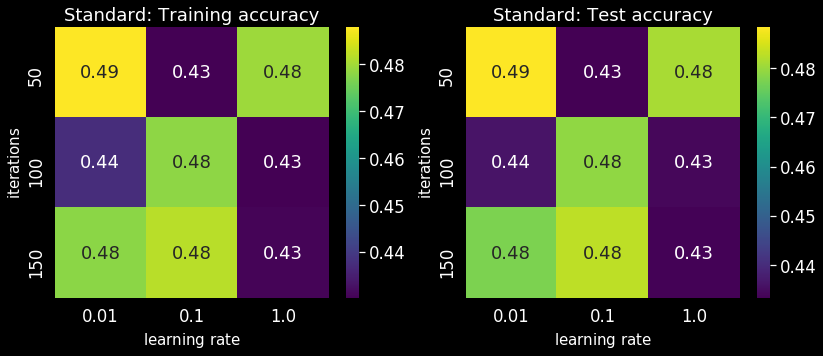

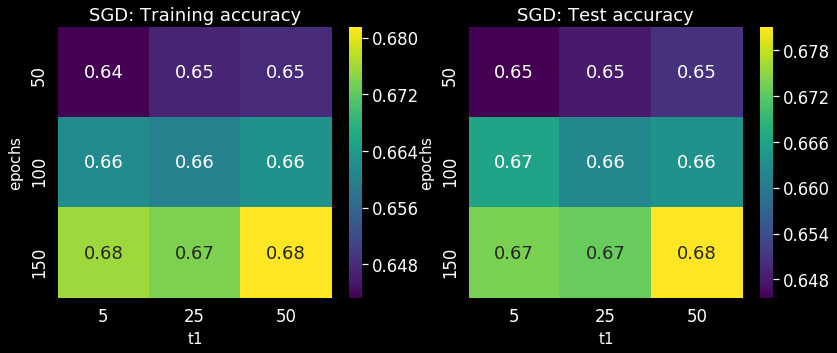

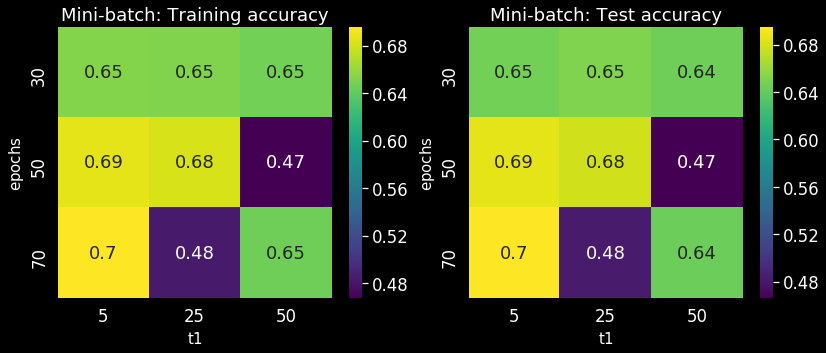

In [9]:
fontsize = 15

x=[str(i) for i in etas]
y=[str(i) for i in iterationNumbers]

fig, (ax, ax2) = plt.subplots(1,2, figsize = (13.5,5))
seaborn.heatmap(accuracyTrainStandardGD.T, annot=True, ax=ax, cmap='viridis')
ax.set_title('Standard: Training accuracy')
ax.set_xticklabels(x) 
ax.set_yticklabels(y)
ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
ax.set_ylabel('$\\mathrm{iterations}$',fontsize=fontsize)

seaborn.heatmap(accuracyTestStandardGD.T, annot=True, ax=ax2, cmap='viridis')
ax2.set_xticklabels(x)
ax2.set_yticklabels(y)
ax2.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
ax2.set_ylabel('$\\mathrm{iterations}$',fontsize=fontsize)
ax2.set_title('Standard: Test accuracy')


x=[str(i) for i in t1s]
y=[str(i) for i in epochSGDnumbers]

fig, (ax, ax2) = plt.subplots(1,2, figsize = (13.5,5))
seaborn.heatmap(accuracyTrainSGD.T, annot=True, ax=ax, cmap='viridis')
ax.set_title('SGD: Training accuracy')
ax.set_xticklabels(x) 
ax.set_yticklabels(y)
ax.set_xlabel('$\\mathrm{t1}$',fontsize=fontsize)
ax.set_ylabel('$\\mathrm{epochs}$',fontsize=fontsize)

seaborn.heatmap(accuracyTestSGD.T, annot=True, ax=ax2, cmap='viridis')
ax2.set_xticklabels(x)
ax2.set_yticklabels(y)
ax2.set_xlabel('$\\mathrm{t1}$',fontsize=fontsize)
ax2.set_ylabel('$\\mathrm{epochs}$',fontsize=fontsize)
ax2.set_title('SGD: Test accuracy')


x=[str(i) for i in t1s]
y=[str(i) for i in epochNumbers]

fig, (ax, ax2) = plt.subplots(1,2, figsize = (13.5,5))
seaborn.heatmap(accuracyTrainMiniBatch.T, annot=True, ax=ax, cmap='viridis')
ax.set_title('Mini-batch: Training accuracy')
ax.set_xticklabels(x) 
ax.set_yticklabels(y)
ax.set_xlabel('$\\mathrm{t1}$',fontsize=fontsize)
ax.set_ylabel('$\\mathrm{epochs}$',fontsize=fontsize)

seaborn.heatmap(accuracyTestMiniBatch.T, annot=True, ax=ax2, cmap='viridis')
ax2.set_xticklabels(x)
ax2.set_yticklabels(y)
ax2.set_xlabel('$\\mathrm{t1}$',fontsize=fontsize)
ax2.set_ylabel('$\\mathrm{epochs}$',fontsize=fontsize)
ax2.set_title('Mini-batch: Test accuracy')

#plt.tight_layout()
#plt.show()

__Figure 6:__ Accuracy different combinations of learning and iteration parameters. Standard gradient descent (top), stochastic gradient descent (middle) and mini-batch (bottom). Own logistic class. <br>
_The difference between training and testing accuracy is always small. All optimizers performs poorly, with stadnard gradient descent worst and mini-batch best._ <br>

We see that the standard gradient descent does rather poorly. At best te accuracy for the standard gradient descent if 0.49 for both training and test set. The optimal learning rate depends on the number of iterations. <br>

The stochastic gradient descent does significanlty better than the standard gradient descent. However, the performance of the stochastic gradient descent is not very good. At best the stochastic gradient descent has accuracies of approximately 0.68 for both training and test sets. The number of epochs barely affects the results, while the accuracy decreases with the learning rate variable $t_1$. $t_1$ relates to the learning rate by $\eta(t; t_0, t_1) = \frac{t_0}{t+t_1}$. <br>

The mini-batch gradient descent, with training and testing accuracy of respectively 0.70 and 0.70, has the best performance. Still the performance of mini-batch can not be said to be impressive. The best performance is found for the lowest epoch number.<br>

Mehta et al. (2018) in their [notebook 6](https://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB_CVII-logreg_ising.html) do the same calculations using Sci-Kit learns. For the lowest regularization value and stochastic gradient descent with the same number of iterations as we applied for the standard gradient descent, they get accuracies of 0.48 and 0.47 for training and testing. These values are close to the values we got with standard gradient descent. <br>

Since Mehta et al. (2018) are using an optimal learning rate, and we get about the same result with standard gradient descent, we do not believe there is much to gain on changing our learning rate. We have tried increasing the iteration number from 100 to 1000, but that changed the accuracy very little. <br>

The standard gradient descent shoiuld converge to the global minima in the case of logistic regression. The cost function applied, the cross entropy, is convex. The above results suggests that it would take a very long time for the standard gradient descent to reach the global minimum. <br>

Finally we note that Mehta et al. (2018) using  a solver named "liblin" get accuracies close to the accuracies we get wth our mini-batch gradient descent solver. The accuracy values are 0.73 and 0.69 for training and testing respectively both for our mini-batch solver and for the alternative solver used by Mehta et al. (2018). This supports that we might have found the global minima for logistic regression when applying the mini-batch solver.

## Classification: Own neural network
We will now apply our neural network class to the same problem we solved above with logistic regression. We change the output activation function from linear to softmax, since we are now dealing with a classification problem. <br>

The neural network needs many hyperparameters that needs to be decided by the user. In our case the regularization parameter (lmbda), the learning rate (eta), the number of epcochs (epochs), the batch size (batch_size) and the number of hidden neurons (n_hidden_neurons) are hyperparameters which we as users must determine. We will now test the dependency of our results on the hyperparameters for the learning rate and for the number of hidden layer neurons. <br>

In [6]:
from  tensorflow.keras.utils import to_categorical

Y_train_onehot, Y_test_onehot = to_categorical(Y_train), to_categorical(Y_test)
epochs = 100
batch_size = 30
lmbd = 0.#0.01
n_categories = 2
activationFunctionHidden='sigmoid'
activationFunctionOutput='softMax'

etas = np.logspace(-3, -1, 3)
n_hidden_neurons = [1,50, 100]

models = np.zeros((len(etas), len(n_hidden_neurons)), dtype=object)
accuracyTrain = np.zeros((len(etas), len(n_hidden_neurons)))
accuracyTest = np.zeros((len(etas), len(n_hidden_neurons)))

for i, eta in enumerate(etas):
    for j, nHiddenNeurons in enumerate(n_hidden_neurons):
        dnn = NeuralNetwork(X_train,Y_train_onehot, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                    n_hidden_neurons=nHiddenNeurons, n_categories=n_categories, 
                   activationFunctionHidden=activationFunctionHidden, activationFunctionOutput=activationFunctionOutput)
        dnn.train()
        models[i][j] = dnn
        accuracyTrain[i][j] = accuracy_score(Y_train, dnn.predict(X_train))
        accuracyTest[i][j] = accuracy_score(Y_test, dnn.predict(X_test))

/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in exp


Next we make plot of the output from the neural network.

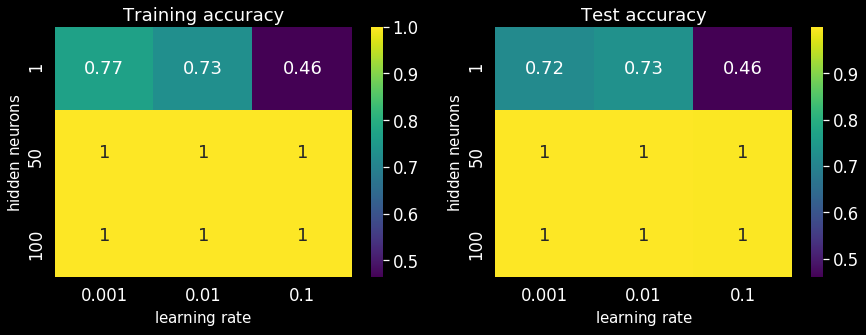

In [7]:
x=[str(i) for i in etas]
y=[str(i) for i in n_hidden_neurons]

fontsize = 15

fig, (ax, ax2) = plt.subplots(1,2, figsize = (12.5,5))
seaborn.heatmap(accuracyTrain.T, annot=True, ax=ax, cmap='viridis')
ax.set_title('Training accuracy')
ax.set_xticklabels(x) 
ax.set_yticklabels(y)
ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)

seaborn.heatmap(accuracyTest.T, annot=True, ax=ax2, cmap='viridis')
ax2.set_xticklabels(x)
ax2.set_yticklabels(y)
ax2.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
ax2.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)
ax2.set_title('Test accuracy')

plt.tight_layout()

plt.show()

#print(accuracyTest)

__Figure 7:__ Accuracy for different learning rates and neuron numbers. Classification. Own Neural network. <br>
_For the two highest number of hidden neurons the accuracy is 99 or 100 per cent for all learning rates for both training and testing. The optimal number of hidden neurons is larger than one._ <br>

Only the case with la single hidden neuron gives non-perfect accuracy. The highest learning rate gives slihtly lower accuracy in the test set.

## Classification: NN Keras
As a test, we run a Neural network in Keras with the same input as we used for our own Neural network.

In [8]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu', input_dim=X_train.shape[1]))#128 neumberof neurans in the present layer
model.add(tf.keras.layers.Dense(Y_train_onehot.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
print(model.summary())

history = model.fit(X_train,
                    Y_train_onehot, 
	epochs=100, 
	batch_size=30,
	validation_data=[X_test, Y_test_onehot])#Y_test

#print('accuracy', model.evaluate(X_test, y_test))
#plt.plot(history.history['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                80050     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 80,152
Trainable params: 80,152
Non-trainable params: 0
_________________________________________________________________
None
Train on 65000 samples, validate on 65000 samples
Epoch 1/100
65000/65000 [==============================] - 6s 89us/step - loss: 0.0182 - acc: 0.9960 - val_loss: 0.0052 - val_acc: 0.9994
Epoch 2/100
65000/65000 [==============================] - 6s 90us/step - loss: 0.0034 - acc: 0.9994 - val_loss: 0.0041 - val_acc: 0.9995
Epoch 3/100
65000/65000 [==============================] - 6s 93us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0028 - val_acc: 0.9995
Epoch 4/100
65000/65000 [==============================] - 6s 86u

Epoch 53/100
65000/65000 [==============================] - 6s 98us/step - loss: 5.6279e-05 - acc: 1.0000 - val_loss: 1.9362e-04 - val_acc: 1.0000
Epoch 54/100
65000/65000 [==============================] - 6s 97us/step - loss: 5.5112e-05 - acc: 1.0000 - val_loss: 1.9297e-04 - val_acc: 1.0000
Epoch 55/100
65000/65000 [==============================] - 6s 96us/step - loss: 5.3985e-05 - acc: 1.0000 - val_loss: 1.9077e-04 - val_acc: 1.0000
Epoch 56/100
65000/65000 [==============================] - 6s 99us/step - loss: 5.2910e-05 - acc: 1.0000 - val_loss: 1.8790e-04 - val_acc: 1.0000
Epoch 57/100
65000/65000 [==============================] - 6s 95us/step - loss: 5.1866e-05 - acc: 1.0000 - val_loss: 1.8347e-04 - val_acc: 1.0000
Epoch 58/100
65000/65000 [==============================] - 6s 95us/step - loss: 5.0857e-05 - acc: 1.0000 - val_loss: 1.8357e-04 - val_acc: 1.0000
Epoch 59/100
65000/65000 [==============================] - 6s 98us/step - loss: 4.9907e-05 - acc: 1.0000 - val_loss: 

__Table 3:__ Keras classification neural network. <br>
_Also Keras gives very good model fits both for training and testing sets. <br>

We see that also Keras produce 100 % accuracy for both the training and the testing set, which suggests that our neural network class works fine for classification.

# Conclusions
In this report we have studied a regression problem and a classification problem applying different methods. Both problems have been related to the Ising model. We have used own developed code for almost all methods. The results have been compared to the results obtained by the packages Sci-Kit learn and Keras. <br>

In the regression scenario we estimated models relating the spin configurations of the Ising model to the energy. First we developed a class with the classical regression techniques OLS and Ridge. We showed that our class reproduces results from Sci-Kit learn's corresponding methods almost exaclty. Toghether with the Lasso-method from Sci-Kit learn we estimated the parameters for all different spin-pairs. All models gave largest parameter values for the neigboring spins, which is the correct solution. Only the Lasso-model was able to get the solution fully correct. Optimal values of regularization for the Lasso and Ridge models was identified. Both the parameter value estimates and the performance measures correspond very well with the results of Mehta et al. (2018). A variance decomposition of the testing MSE for Lasso and Ridge as function of regularization degree was performed using a bootstrap function we devloped from scratch. The bias-variance decomposition shows that is change in the variance that drives the change in testing MSE. <br>

Finally we develop our own Neural network with one hidden layer. Our neural network class gives pretty similar results to Keras neural network for a simple test regression problem. For the Ising-model regression problem, the results from our neural network and Keras do not correspond well. Our neural network gives a very good training fit for several learning rates and regularization parameters. The performance on the training set from our neural network seems to match Keras. However, the performance of our neural network on the testing set is very poor. The R2 scores on the testing set for our neural netowrk are below 0.5. Keras, on the other hand, gets perfect accuracy also on the testing set. Simulations with different regularization parameters indicates the poor testing set performance of our neural network is not due to overfitting. Also there seems to be little to gain in test set performance of our neural network from changing the learning rate. <br>

For the classification problem we made models for classfiying the phase type of a 2D Ising-model. We developed our own logistic regression class. The performance of this logistic regression class was poor, and depends on the chosen optimzation solver. We find that the mini-batch stochastic gradient descent does best, with testing accuracy aorund 70 %, while the standard gradient descent does worst with testing accuracy below 50 %. The stochastic gradient descent did almost as well as the mini-batch stochastic gradient descent. There seems to be little gain from increasing the number of iterations or changing the learning rate furhter. The result for the standard gradient descent corresponds well with those found by Mehta et al. (2018) with gradient descent. Furthermore, the mini-barch stochastic gradient descent results corresponds well with the results Mehta et al. (2018) get using the liblin-solver. <br>

Our neural network worked very well on the Ising-model classification problem. The performance of our neural network was much better than with the logistic regression. Except for the single neuron hidden layer model, our neural network gave almost perfect accuracy both for the training and the testing set for all training rates. The results of our neural network match the results we get by applying Keras with the same inputs. <br>

For the problems studied in this report, neural networks clearly outperforms logistic regression for classification problems. For the regression problems, the classical methods do better than neural networks. An extra challenge when using the neural networks, is the hyperparameters. It is hard to know which values to set. We have found that the performance of the neural networks are highly senstive to the hyperparameters. For instance a sligth change in the values of the initial weights resultet in the exploding gradients in the regression problem. Hence, when working with neural networks, one must expect to spend a considerable amount of time analysing the hyperparameters.



# References
Hjorth-Jensen, M. (2018). Data Analysis and Machine Learning: Logistic Regression. <br>
https://compphysics.github.io/MachineLearning/doc/pub/LogReg/html/LogReg.html <br>

Mehta, P., Wang, C.-H., Day, A., and Richardson, C. (2018). A high-bias, low-variance introduction to Machine Learning for physicists. <br> 
https://arxiv.org/pdf/1803.08823.pdf <br>

Mehta, P., Wang, C.-H., Day, A., and Richardson, C. Notebook 4. Mehta, P., Wang, C.-H., Day, A., and Richardson, C. <br>https://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB_CVI-linreg_ising.html <br>

Mehta, P., Wang, C.-H., Day, A., and Richardson, C. Notebook 6. Mehta, P., Wang, C.-H., Day, A., and Richardson, C. <br>https://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB_CVII-logreg_ising.html <br>
